# Implementing the Simplest Neural Network

In [1]:
%matplotlib inline

In [2]:
import time
import numpy
import pandas
import matplotlib

## Introduction

This walk-through of creating a simple neural network to predict outputs given an input is derived from [Neural Networks from Scratch with Python Code and Math in Detail](https://medium.com/towards-artificial-intelligence/building-neural-networks-from-scratch-with-python-code-and-math-in-detail-i-536fae5d7bbf).  I found that walk through had a few errors and some confusing/imprecise language, so I made this notebook to walk me through each step.  This exercise makes most sense if you give that page a skim first, since I assume that you already have a basic understanding of what a neural network _does_.  Here, we describe mathematically how a neural network actually works.

We implement a neural network using only numpy, then go on to implement the same network using PyTorch to illustrate what PyTorch is doing underneath its convenient interface.  Via the same random number seeds, our hand-rolled version is mathematically identical to the much more terse PyTorch version.

Finally, if you're viewing this in webpage form, you can find the [actual Jupyter Notebook in GitHub](https://github.com/glennklockwood/limelead/blob/master/notebooks/perceptron.ipynb).

## Problem statement

Here, we build a small linear model (a [perceptron](https://en.wikipedia.org/wiki/Perceptron)) that classifies an input as one thing or another (_binary classification_) via a couple of input parameters.

Specifically, we create a model of a simple OR gate with two inputs and one output.  OR gates have the following behavior:

1. If both inputs are 0 (off), the output is 0 (off)
2. If both inputs are 1 (on), the output is 1 (on)
3. If either input is 1 (on), the output is still 1 (on)

We want a model, $f(x)$, that takes two inputs ($x$) and returns an output of either 0 or 1 based on the value of those inputs.

Let's first build a set of observations that capture this behavior as if we were experimenting with an OR gate ourselves:

In [3]:
inputs = pandas.DataFrame(
    [[0, 0],
    [0, 1],
    [1, 0],
    [1, 1]],
    columns=["input 1", "input 2"])
inputs.index.name = "observation #"

ground_truth = pandas.Series([0, 1, 1, 1], name="true output", index=inputs.index)

print("Inputs and true outputs (truth table) are:")
print(pandas.concat((inputs, ground_truth), axis=1))

Inputs and true outputs (truth table) are:
               input 1  input 2  true output
observation #                               
0                    0        0            0
1                    0        1            1
2                    1        0            1
3                    1        1            1


## Defining our model

### Linear model

The model we're using to predict our output values, $f(x, w)$, is based on a linear model $y(x)$ at its core:

$ y(x) = x \cdot w + b $

where

- $x$ are our observed inputs (the _independent_ variables)
- $w$ are empirical "weight" parameters
- $b$ is an empirical "bias" parameter

The magic of this model is in figuring out what values for our empirical parameters, $w$ and $b$, result in the model producing our true outputs for each set of given inputs.

In [4]:
def linear(x, weights, bias):
    """Linear model function
    """
    return numpy.dot(x, weights) + bias

In our specific case, we have two inputs, so the actual model will be

$ y(x_1, x_2) = x_1 w_1 + x_2 w_2 + b $

or more generally,

$ y(\mathbf{x}) = \mathbf{x} \cdot \mathbf{w} + b $

The lattermost form is the most rigorous, but I may just refer to _vectors_ like $\mathbf{x}$ and $\mathbf{w}$ as $x$ and $w$ hereafter to match how they are represented in Python.

### Activation function

We also have to shove this $y(x)$ through an "activation function" $A(x)$ to make so the model can only return values between 0 (off) and 1 (on) though.  We arbitrarily choose a sigmoid function to accomplish this:

$ \displaystyle A(y) = \frac{1}{1 + e^{-y}} $

Which can be defined in Python as follows:

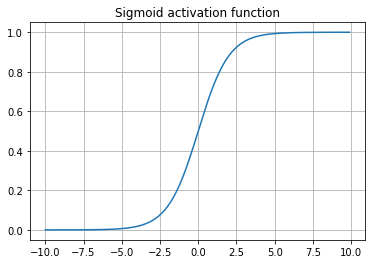

In [5]:
def sigmoid(x):
    """Activation function
    """
    return 1.0 / (1.0 + numpy.exp(-x))

matplotlib.pyplot.plot(numpy.arange(-10, 10, 0.1), sigmoid(numpy.arange(-10, 10, 0.1)), label="sigmoid")
matplotlib.pyplot.grid()
matplotlib.pyplot.title("Sigmoid activation function")
pass

Because we're nesting our linear function in an activation function, $f(x, w)$ looks pretty gnarly if you expand it out:

$ f(x) = A(y(x)) = A(x \cdot w + b) = \frac{1}{1 + e^{-{x} \cdot w - b}} $

But I like to really think of our model as $ y(x) = x \cdot w + b $ with some special sauce splashed on top to make sure our output values aren't unbounded.  If we didn't have an activation function, our linear model $y(x)$ would predict values that could go to infinity which

1. doesn't represent the reality of the true outputs (we know that they can only vary from 0 to 1)
2. will cause our model to not _converge_ (approach the right answer) very well

You can confirm this yourself by defining `sigmoid(x)` to just `return x`.  There's a much more rigorous explanation of what the activation function plays in neural networks, so please look it up if you're interested.

Now that we have a model in mind, we have to figure out how to _parameterize_ to get values for our weights 

## Setting up gradient descent

We have a choice of model (a linear one wrapped in an activation function), so now we need to figure out what values of our empirical parameters $w$ and $b$ should be to make the model produce outputs that most closely track reality.  To do this, we use [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent).  Its formal definition is

$ w_{t+1} = w_{t} - R \cdot \frac{d}{dw}E(x, w_{t}) $

where $R$ is the "learning rate," an empirical _hyperparameter_.  Whereas $w$ and $b$ are parameters that relate inputs to outputs, $R$ is a hyperparameter because it doesn't relate to what's being modeled as much as it relates to the model itself.

$E(x, w)$ is a "loss function" that describes how far away our empirical model $f(x, w)$ is from ground truth values $ f_{0} $, and the goal of this whole exercise with gradient descent is to minimize the loss, or make the difference between our model and reality as small as possible.

Our first order of business to actually calculate some numbers and evolve our model is to define some starting values of our empirical parameters: weights, bias, and learning rate.  Since our inputs $x$ are actually an array, $w$ must also be an array with one value for each of our input variables in $x$:

In [6]:
numpy.random.seed(seed=1)
print("Setting initial weights to random values.")
weights = numpy.random.rand(inputs.shape[1], 1)

print(pandas.DataFrame(weights, index=inputs.columns, columns=["weight"]))

bias = numpy.random.rand(1)[0]
print("Setting starting bias to a random value: {:4f}".format(bias))

Setting initial weights to random values.
           weight
input 1  0.417022
input 2  0.720324
Setting starting bias to a random value: 0.000114


Our bias parameter $b$ and learning rate (hyper)parameter $R$ are both scalar values.

We can set the bias to some random value because gradient descent will find its optimal value for us.

Learning rate is a constant that we set--it needs to be small enough for the interative method to not go haywire by skipping around too much between successive iterations, but not so small as to take a gazillion iterations to approach the optimal weights.

In [7]:
learning_rate = 0.05
print("Setting learning rate to {} based on prior experience.".format(learning_rate))

Setting learning rate to 0.05 based on prior experience.


## Applying gradient descent

How do we actually _solve_ our gradient descent equation, $ w_{t+1} = w_{t} - R \cdot \frac{d}{dw}E(x, w_{t}) $?  That is, how do we train our model?  Well, we know the following:

- $w_{t}$:  we randomly defined them above
- $ y(\mathbf{x}) = \mathbf{x} \cdot \mathbf{w} + b  $
- $ f(y) = \frac{1}{1+e^{-y}}$
- _learning rate_ $R = 0.05$

So we just need to figure out what $\frac{dE}{dw}$ is--or how our _loss function_ varies as our _weights_ vary for a given set of input values $x$.

We can pretty arbitrarily define our _loss function_.  This form seems to capture the right idea:

$ E = abs \left ( f_{0} - f \right ) $

As the difference between our predicted $f$ and ground truth outputs $f_{0}$ get bigger, our error gets bigger.  Easy.

Then we break apart $\frac{\partial E}{\partial w}$ using the chain rule:

$ \displaystyle \frac{\partial E}{\partial w} =
        \frac{\partial E}{\partial f}
  \cdot \frac{\partial f}{\partial y}
  \cdot \frac{\partial y}{\partial w} $

The derivations of these three components are pretty straightforward based on our definitions of $y(\mathbf{x})$, $f(y)$, and $E$ above--apply your college calculus to derive them yourself, or just use Wolfram Alpha!  They come out to be:

1. $ \frac{\partial E}{\partial f} = \frac{abs \left ( f - f_{0} \right )}{f - f_{0}} $
2. $ \frac{\partial f}{\partial y} = f \left ( 1 - f \right ) $
3. $ \frac{\partial y}{\partial w} = x_{0} $

With this, we can just calculate $w_{t}$ for $t \rightarrow \infty$ using the gradient descent formula above to approach the optimal set of weights that minimize our loss function and thereby produce a model that approximates reality.  So as not to spend infinite time calculating for $t \rightarrow \infty$, we choose $t \rightarrow 10000$:

In [8]:
NUM_ITERATIONS = 10000

Then start the gradient descent process to slowly nudge $w$ and $b$ towards optimal values!

In [9]:
# convert dataframe bits into arrays for processing
inputs_array = inputs.to_numpy()
truth_array = ground_truth.to_numpy().reshape(-1, 1)

x = inputs_array
t0 = time.time()
for i in range(NUM_ITERATIONS):
    y = linear(x, weights, bias)
    f = sigmoid(y)
    
    error = numpy.abs(f - truth_array)
    
    # calculate out partial derivatives for each input
    dE_df = error/(f - truth_array)
    df_dy = sigmoid(y) * (1.0 - sigmoid(y))
    dy_dw = x
    dE_dy = dE_df * df_dy
    dE_dw = numpy.dot(dy_dw.T, dE_dy)  # dy_dw = x

    # update weights and biases - the error is the sum of error over each input
    weights -= learning_rate * dE_dw
    bias -= learning_rate * dE_dy.sum()

    if i % (NUM_ITERATIONS / 10) == 0:
        print("error at step {:5d}: {:10.2e}".format(i, error.sum()))

print("Final weights: {}".format(weights.flatten()))
print("Final bias:    {}".format(bias))
print("{:d} iterations took {:.1f} seconds".format(NUM_ITERATIONS, time.time() - t0))

error at step     0:   1.47e+00
error at step  1000:   2.33e-01
error at step  2000:   1.09e-01
error at step  3000:   6.98e-02
error at step  4000:   5.10e-02
error at step  5000:   4.00e-02
error at step  6000:   3.29e-02
error at step  7000:   2.79e-02
error at step  8000:   2.43e-02
error at step  9000:   2.14e-02
Final weights: [9.98578506 9.98589032]
Final bias:    -4.52752860008788
10000 iterations took 1.9 seconds


We now have an optimal set of weights $\mathbf{w}$.  To make predictions using these weights, we just run our inputs through $ f(x) = A(y(\mathbf{x})) = A(\mathbf{x} \cdot \mathbf{w} + b)$.

## Predicting outputs

With our set of weights and our $f(x)$, we are ready to begin predicting outputs for a set of inputs--inferencing.

In [10]:
predicted_output = sigmoid(numpy.dot(x, weights) + bias)
predicted_output = pandas.DataFrame(
    predicted_output,
    columns=["predicted output"],
    index=inputs.index)

print(predicted_output)

               predicted output
observation #                  
0                      0.010692
1                      0.995758
2                      0.995757
3                      1.000000


and we strap this on to our truth table to see how we did compared to the true outputs:

In [11]:
print(pandas.concat((
    inputs,
    ground_truth,
    predicted_output),
    axis=1))

               input 1  input 2  true output  predicted output
observation #                                                 
0                    0        0            0          0.010692
1                    0        1            1          0.995758
2                    1        0            1          0.995757
3                    1        1            1          1.000000


## Implementing our model in PyTorch

We implemented the above linear model using numpy and some hand-calculated derivatives to iterate through the gradient descent algorithm.  Higher-level frameworks like PyTorch simplify this process by providing canned versions of these operations that allow us to

1. more quickly swap algorithms and functions in and out to see the effects of changing our activation function, loss function, and other hyperparameters
2. automatically calculate derivatives of our loss function with respect to different variables for us, obviating the need to do pen-and-paper calculus to derive the correct values to feed into gradient descent
3. easily offload these processes to accelerators like GPUs with only a few extra lines of code

Here, let's use the PyTorch framework.

In [12]:
import torch

We'll implement the same function which is a linear function at its core:

$ y(\mathbf{x}) = \mathbf{x} \cdot \mathbf{w} + b $

which is then wrapped in our sigmoid function:

$ A(x) = \frac{1}{1 + e^{-x}} $

which means

$ f(x) = A(y(x)) $

Instead of defining Python functions for $y(x)$ and $A(y)$ (as we did above with `linear(x, weights, bias)` and `sigmoid(x)`, we can assemble the model using PyTorch using canned versions of these functions:

In [13]:
model = torch.nn.Sequential(
    torch.nn.Linear(inputs.shape[1], 1),
    torch.nn.Sigmoid()
)

We use the `torch.nn.Sequential` _container_ to define a model that simply feeds the output of the first function (`Linear()`) into the second (`Sigmoid()`) to produce $A(y(x))$.

Our $y(x)$ linear model is implemented in PyTorch as `torch.nn.Linear(num_inputs, num_outputs)`.

Similarly, the sigmoid function is provided by PyTorch as `torch.nn.Sigmoid()`.  We can visually confirm that the two functions produce the same output:

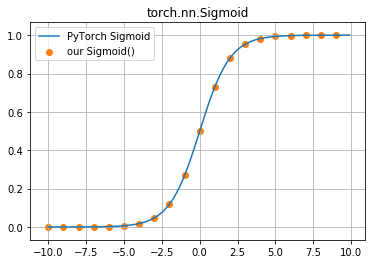

In [14]:
x = numpy.arange(-10, 10, 0.1)
matplotlib.pyplot.plot(x, torch.nn.Sigmoid()(torch.from_numpy(x)).detach().numpy(), label="PyTorch Sigmoid")
matplotlib.pyplot.scatter(x[::10], sigmoid(x[::10]), color='C1', label="our Sigmoid()")
matplotlib.pyplot.grid()
matplotlib.pyplot.legend()
matplotlib.pyplot.title("torch.nn.Sigmoid")
pass

Just as before, we also set initial weights and biases for the linear part of our model.  This isn't strictly necessary with PyTorch since it will automatically initialize them to random values, but we initialize our PyTorch model with the same weights and biases as our hand-rolled version so that we can compare the gradient descent processes and make sure we are getting numerically identical results and behavior.

In [15]:
numpy.random.seed(seed=1) # use same initial seed as before
with torch.no_grad():
    # torch.rand() is faster, but we use numpy to re-use the same random starting weights/biases
    model[0].weight = torch.nn.Parameter(torch.from_numpy(numpy.random.rand(1, inputs.shape[1])))
    print("Starting weights: {}".format(model[0].weight.flatten()))
    model[0].bias = torch.nn.Parameter(torch.from_numpy(numpy.random.rand(1, 1)))
    print("Starting bias: {}".format(model[0].bias.flatten()))

Starting weights: tensor([0.4170, 0.7203], dtype=torch.float64, requires_grad=True)
Starting bias: tensor([0.0001], dtype=torch.float64, requires_grad=True)


With our model defined and our initial weights and biases set, we can apply gradient descent.  A couple of notes:

1. We have to convert our numpy array into PyTorch tensors.  They're functionally equivalent, but tensors have extra magic that allows PyTorch to track enough information about them to calculate gradients of them on demand.

2. Our simple loss function is provided by PyTorch as `torch.nn.L1Loss()` which we provide here.

3. We use `torch.optim.SGD()` as our _optimizer_ - this implements gradient descent as defined earlier ($ w_{t+1} = w_{t} - R \cdot \frac{d}{dw}E(x, w_{t}) $).  It actually implements _stochastic gradient descent_, but we aren't using the extra SGD parameters, and we are feeding it all of our inputs at once which renders it numerically identical to standard gradient descent.

4. By using PyTorch tensors as inputs and ouputs to our loss function, we get not only the error as calculated based on the weights and bias at each step, but we can call the `backward()` method on that error tensor to calculate the derivatives of this loss function with respect to the weights and biases.  We don't have to do any calculus by hand!

This last point is probably the most important thing PyTorch gives us to simplify the process of training model by implicitly tracking everything needed to calculate the gradient.  This has the downside that PyTorch is implicitly modifying variables behind the scenes without explicitly telling us; specifically, `backward()` not only calculates gradients, it updates parts of our model to store those gradients.

In [16]:
# pytorch is more sensitive about types, so we explicitly cast our integer input arrays as float64
inputs_tensor = torch.from_numpy(inputs.to_numpy(dtype=numpy.float64))
truth_tensor = torch.from_numpy(ground_truth.to_numpy(dtype=numpy.float64).reshape(-1, 1))

# use PyTorch's implementation of our loss = abs(f0 - f)
loss = torch.nn.L1Loss(reduction='sum')

# use PyTorch's implementation of gradient descent
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

model.train()
x = inputs_tensor
t0 = time.time()
for i in range(NUM_ITERATIONS):
    f = model(x)

    error = loss(f, truth_tensor)

    # erase memory of gradients at previous step
    optimizer.zero_grad()

    # compute gradient of loss function
    error.backward()

    # use computed gradient to update weights and bias
    optimizer.step()

    if i % (NUM_ITERATIONS / 10) == 0:
        print("error at step {:5d}: {:10.2e}".format(i, error.sum()))

print("Final weights: {}".format(next(model.parameters()).detach().numpy().flatten()))
print("Final bias:    {}".format(list(model.parameters())[-1].item()))
print("{:d} iterations took {:.1f} seconds".format(NUM_ITERATIONS, time.time() - t0))

error at step     0:   1.47e+00
error at step  1000:   2.33e-01
error at step  2000:   1.09e-01
error at step  3000:   6.98e-02
error at step  4000:   5.10e-02
error at step  5000:   4.00e-02
error at step  6000:   3.29e-02
error at step  7000:   2.79e-02
error at step  8000:   2.43e-02
error at step  9000:   2.14e-02
Final weights: [9.98578506 9.98589032]
Final bias:    -4.52752860008788
10000 iterations took 8.6 seconds


Because of the implicit changes triggered by this _autograd_ functionality, we have to be _explicit_ when we don't want it to kick in by wrapping such tensor operations in `with torch.no_grad():`.  PyTorch's builtin gradient descent "optimizer" that we use takes care of this for us in this case.  Exactly how PyTorch's _autograd_ functionality works is illustrated very well in [A Gentle Introduction to torch.autograd](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html).

Relatedly, we also explicitly set the model to be in training mode (`model.train()`) before training, then turn it off before inference to prevent inference from unintentionally changing our model.

In [17]:
model.eval()

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)

Now with our trained model, we can begin inferencing just as we did before, and we see that our predicted outputs are identical to our hand-rolled model before.

In [18]:
predicted_output = model(inputs_tensor).detach().numpy()
predicted_output = pandas.DataFrame(
    predicted_output,
    columns=["predicted output"],
    index=inputs.index)

print(pandas.concat((
    inputs,
    ground_truth,
    predicted_output),
    axis=1))

               input 1  input 2  true output  predicted output
observation #                                                 
0                    0        0            0          0.010692
1                    0        1            1          0.995758
2                    1        0            1          0.995757
3                    1        1            1          1.000000


## Bonus: Training on a GPU

Our PyTorch implementation took a _lot_ longer than our hand-rolled implementation because the relative cost of training and evaluating our model was low compared to the overheads of PyTorch's automatic differentiation.  However PyTorch also greatly simplifies porting models to a GPU.  If you have a GPU, you can try running our PyTorch version of the model on it by adding a few extra lines.

First define our GPU.

In [19]:
device = torch.device('cuda')

Nothing special as far as initializing weights and defining our loss and optimizer functions.

In [20]:
# reinitialize weights
numpy.random.seed(seed=1)
with torch.no_grad():
    model[0].weight = torch.nn.Parameter(torch.from_numpy(numpy.random.rand(1, inputs.shape[1])))
    print("Starting weights: {}".format(model[0].weight.flatten()))
    model[0].bias = torch.nn.Parameter(torch.from_numpy(numpy.random.rand(1, 1)))
    print("Starting bias: {}".format(model[0].bias.flatten()))

# define our loss function and optimizer
loss = torch.nn.L1Loss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Starting weights: tensor([0.4170, 0.7203], dtype=torch.float64, requires_grad=True)
Starting bias: tensor([0.0001], dtype=torch.float64, requires_grad=True)


We just have to make sure to send our model and input tensors to the GPU before we begin.  Everything else remains as it was, and all calls to our model will execute on the GPU since that's where we copied it.

In [21]:
# send everything to the GPU!
model = model.to(device)
inputs_tensor = torch.from_numpy(inputs.to_numpy(dtype=numpy.float64)).to(device)
truth_tensor = torch.from_numpy(ground_truth.to_numpy(dtype=numpy.float64).reshape(-1, 1)).to(device)

model.train()
x = inputs_tensor
t0 = time.time()
for i in range(NUM_ITERATIONS):
    f = model(x)
    error = loss(f, truth_tensor)
    optimizer.zero_grad()
    error.backward()
    optimizer.step()
    if i % (NUM_ITERATIONS / 10) == 0:
        print("error at step {:5d}: {:10.2e}".format(i, error.sum()))

# get our model back from the GPU so we can manipulate and print it from the CPU
model = model.cpu()
print("Final weights: {}".format(next(model.parameters()).detach().numpy().flatten()))
print("Final bias:    {}".format(list(model.parameters())[-1].item()))
print("{:d} iterations took {:.1f} seconds".format(NUM_ITERATIONS, time.time() - t0))

error at step     0:   1.47e+00
error at step  1000:   2.33e-01
error at step  2000:   1.09e-01
error at step  3000:   6.98e-02
error at step  4000:   5.10e-02
error at step  5000:   4.00e-02
error at step  6000:   3.29e-02
error at step  7000:   2.79e-02
error at step  8000:   2.43e-02
error at step  9000:   2.14e-02
Final weights: [9.98578506 9.98589032]
Final bias:    -4.52752860008788
10000 iterations took 23.1 seconds


You may notice that this took _even longer_ on the GPU--again, because this is such an algorithmically simple problem, the high-throughput capability of the GPU isn't able to shine.